In [1]:
import torch
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def preprocess(ds):
    ''' add dimension to concatenate datasets '''
    return ds.expand_dims(dim='month')

In [3]:
# loading climatologies 
# all monthly climatologies included in single variable 

prism = xr.open_mfdataset('C:/Users/SBEALE/Desktop/Cropped_Coarsened_WRF_PRISM/no_overlap/tmax*PRISM_WorldClim.nc', preprocess=preprocess, combine='nested', concat_dim='month')
wrf = xr.open_mfdataset('C:/Users/SBEALE/Desktop/Cropped_Coarsened_WRF_PRISM/no_overlap/tmax*WRF_coarse.nc', preprocess=preprocess, combine='nested', concat_dim='month')
coast = xr.open_dataset('C:/Users/SBEALE/Desktop/Cropped_Coarsened_WRF_PRISM/no_overlap/coast.nc')
dem = xr.open_dataset('C:/Users/SBEALE/Desktop/Cropped_Coarsened_WRF_PRISM/no_overlap/DEM.nc')
lat = xr.open_dataset('C:/Users/SBEALE/Desktop/Cropped_Coarsened_WRF_PRISM/no_overlap/lat.nc')
lon = xr.open_dataset('C:/Users/SBEALE/Desktop/Cropped_Coarsened_WRF_PRISM/no_overlap/lon.nc')

In [4]:
wrf = wrf.sel(longitude=slice(-140.795, -114), latitude=slice(65, 47.8))
prism = prism.sel(longitude=slice(-140.795, -114), latitude=slice(65, 47.8))
dem = dem.sel(longitude=slice(-140.81, -114), latitude=slice(65, 47.8))
lat = lat.sel(longitude=slice(-140.81, -114), latitude=slice(65, 47.8))
lon = lon.sel(longitude=slice(-140.81, -114), latitude=slice(65, 47.8))
coast = coast.sel(longitude=slice(-140.81, -114), latitude=slice(65, 47.8))

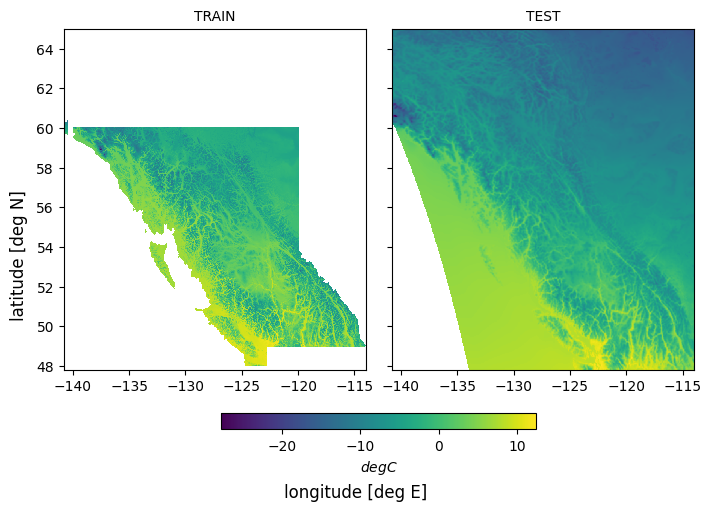

In [5]:
fig, ax = plt.subplots(1, 2, layout='constrained', figsize=(7, 5), sharex=True, sharey=True)

pc1 = ax[0].pcolormesh(prism.longitude, prism.latitude, prism.tmax[2], cmap='viridis', label=r'$m$')
ax[0].set_title(f'TRAIN', fontsize='medium', loc='center')

pc1 = ax[1].pcolormesh(wrf.longitude, wrf.latitude, wrf.tmax[2], cmap='viridis', label=r'$m$')
ax[1].set_title(f'TEST', fontsize='medium', loc='center')

fig.supylabel('latitude [deg N]')
fig.supxlabel('longitude [deg E]')

fig.colorbar(pc1, shrink=0.5, aspect=20, location='bottom', ax=ax[0:2], label=r'$deg C$')

In [6]:
prism_tmax = prism['tmax']
wrf_tmax = wrf['tmax']
coast_dist = coast['dist']
dem_dem = dem['dem']
lat_lat = lat['lat']
lon_lon = lon['lon']

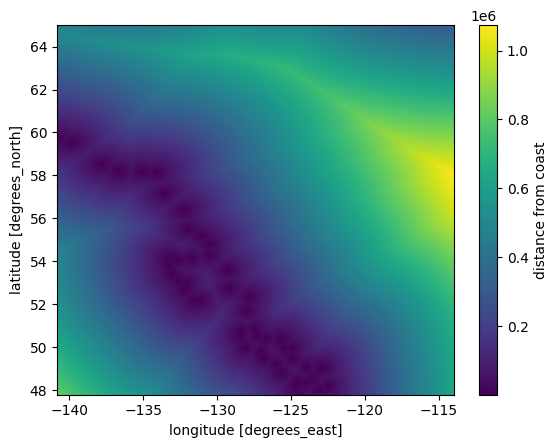

In [7]:
coast.dist.plot(cmap='viridis')

In [8]:
wrf_tens = torch.from_numpy(np.array(wrf.tmax))
months = torch.zeros((12,wrf_tens.shape[1],wrf_tens.shape[2]))
for i in range(0,12):
    months[i] = i+1
months = np.array(months)

In [9]:
wrf

<xarray.Dataset> Size: 20MB
Dimensions:    (month: 12, latitude: 516, longitude: 804)
Coordinates:
  * longitude  (longitude) float64 6kB -140.8 -140.8 -140.7 ... -114.1 -114.0
  * latitude   (latitude) float64 4kB 64.99 64.95 64.92 ... 47.89 47.85 47.82
Dimensions without coordinates: month
Data variables:
    tmax       (month, latitude, longitude) float32 20MB dask.array<chunksize=(1, 516, 804), meta=np.ndarray>
    crs        (month) int32 48B -2147483647 -2147483647 ... -2147483647
Attributes:
    Conventions:  CF-1.4
    created_by:   R packages ncdf4 and terra (version 1.7-78)
    date:         2024-06-24 11:36:32

In [10]:
stand = pd.read_csv('C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_all_months_nonan/standardization.csv')
stand

,var,clim,mean,std
0,tmax,prism,7.012030,8.533417
1,tmax,wrf,5.410508,8.450318
2,dist from coast,prism,212289.020000,161943.800000
3,dem,prism,980.911100,613.356260
4,lat,prism,-126.468094,5.683978
5,lon,prism,54.133880,3.268658


In [11]:
# standardizing all variables 
prism['tmax'] = (prism_tmax - stand['mean'][0])/stand['std'][0]
wrf['tmax'] = (wrf_tmax - stand['mean'][1])/stand['std'][1]
coast['dist'] = (coast_dist - stand['mean'][2])/stand['std'][2]
dem['dem'] = (dem_dem - stand['mean'][3])/stand['std'][3]
lat['lat'] = (lat_lat - stand['mean'][4])/stand['std'][4]
lon['lon'] = (lon_lon - stand['mean'][5])/stand['std'][5]

In [12]:
month_netcdf = wrf.copy(deep=True)
month_netcdf = month_netcdf.rename({'tmax':'months'})

In [13]:
wrf

<xarray.Dataset> Size: 20MB
Dimensions:    (month: 12, latitude: 516, longitude: 804)
Coordinates:
  * longitude  (longitude) float64 6kB -140.8 -140.8 -140.7 ... -114.1 -114.0
  * latitude   (latitude) float64 4kB 64.99 64.95 64.92 ... 47.89 47.85 47.82
Dimensions without coordinates: month
Data variables:
    tmax       (month, latitude, longitude) float32 20MB dask.array<chunksize=(1, 516, 804), meta=np.ndarray>
    crs        (month) int32 48B -2147483647 -2147483647 ... -2147483647
Attributes:
    Conventions:  CF-1.4
    created_by:   R packages ncdf4 and terra (version 1.7-78)
    date:         2024-06-24 11:36:32

In [14]:
month_netcdf

<xarray.Dataset> Size: 20MB
Dimensions:    (month: 12, latitude: 516, longitude: 804)
Coordinates:
  * longitude  (longitude) float64 6kB -140.8 -140.8 -140.7 ... -114.1 -114.0
  * latitude   (latitude) float64 4kB 64.99 64.95 64.92 ... 47.89 47.85 47.82
Dimensions without coordinates: month
Data variables:
    months     (month, latitude, longitude) float32 20MB dask.array<chunksize=(1, 516, 804), meta=np.ndarray>
    crs        (month) int32 48B -2147483647 -2147483647 ... -2147483647
Attributes:
    Conventions:  CF-1.4
    created_by:   R packages ncdf4 and terra (version 1.7-78)
    date:         2024-06-24 11:36:32

In [15]:
for i in range(0,12):
    month_netcdf['months'][i] = months[i]

In [16]:
wrf = wrf.assign(months=month_netcdf['months'])

In [17]:
month_netcdf.months.to_netcdf('C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_all_months_nonan/months_large.nc')
wrf.tmax.to_netcdf('C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_all_months_nonan/wrf_large.nc')
wrf.months.to_netcdf('C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_all_months_nonan/wrf_large.nc', mode='a')
coast.dist.to_netcdf('C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_all_months_nonan/coast_large.nc')
lat.lat.to_netcdf('C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_all_months_nonan/lat_large.nc')
lon.lon.to_netcdf('C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_all_months_nonan/lon_large.nc')
dem.dem.to_netcdf('C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_all_months_nonan/dem_large.nc')
prism.tmax.to_netcdf('C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_all_months_nonan/prism_large.nc')

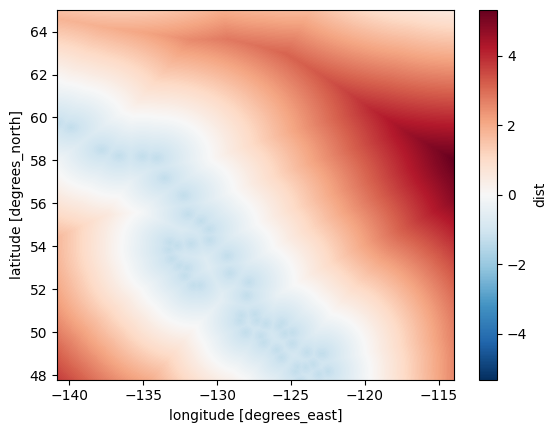

In [18]:
x = xr.open_dataset('C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_all_months_nonan/coast_large.nc')
x.dist.plot()

In [32]:
prism_slope_var = prism_slope_test['slope']
prism_aspect_var = prism_aspect_test['aspect']
prism_tpi_var = prism_tpi_test['TPI']

wrf_slope_var = wrf_slope_test['slope']
wrf_aspect_var = wrf_aspect_test['aspect']
wrf_tpi_var = wrf_tpi_test['TPI']
wrf_dem_var = wrf_dem_test['DEM']

prism_slope_test['slope'] = (prism_slope_var - prism_slope_mean)/prism_slope_std
prism_aspect_test['aspect'] = (prism_aspect_var - prism_aspect_mean)/prism_aspect_std
prism_tpi_test['TPI'] = (prism_tpi_var - prism_tpi_mean)/prism_tpi_std

wrf_slope_test['slope'] = (wrf_slope_var - wrf_slope_mean)/wrf_slope_std
wrf_aspect_test['aspect'] = (wrf_aspect_var - wrf_aspect_mean)/wrf_aspect_std
wrf_tpi_test['TPI'] = (wrf_tpi_var - wrf_tpi_mean)/wrf_tpi_std
wrf_dem_test['DEM'] = (wrf_dem_var - wrf_dem_mean)/wrf_dem_std

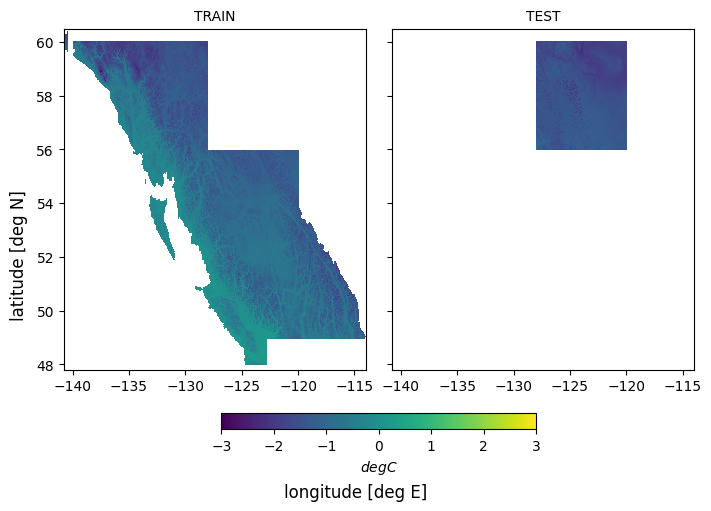

In [33]:
fig, ax = plt.subplots(1, 2, layout='constrained', figsize=(7, 5), sharex=True, sharey=True)

pc1 = ax[0].pcolormesh(prism.longitude, prism.latitude, prism.tmax[1], cmap='viridis', vmin=-3, vmax=3, label=r'$m$')
ax[0].set_title(f'TRAIN', fontsize='medium', loc='center')

pc1 = ax[1].pcolormesh(prism_test.longitude, prism_test.latitude, prism_test.tmax[1], cmap='viridis', vmin=-3, vmax=3, label=r'$m$')
ax[1].set_title(f'TEST', fontsize='medium', loc='center')

fig.supylabel('latitude [deg N]')
fig.supxlabel('longitude [deg E]')

fig.colorbar(pc1, shrink=0.5, aspect=20, location='bottom', ax=ax[0:2], label=r'$deg C$')

In [34]:
prism.tmax.to_netcdf('C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_march_monthly_nonan_extra_cov/prism_train.nc')
wrf.tmax.to_netcdf('C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_march_monthly_nonan_extra_cov/wrf_train.nc')
dem.dem.to_netcdf('C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_march_monthly_nonan_extra_cov/dem_train.nc')
lat.lat.to_netcdf('C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_march_monthly_nonan_extra_cov/lat_train.nc')
lon.lon.to_netcdf('C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_march_monthly_nonan_extra_cov/lon_train.nc')
coast.dist.to_netcdf('C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_march_monthly_nonan_extra_cov/coast_train.nc')

In [35]:
prism_test.tmax.to_netcdf('C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_march_monthly_nonan_extra_cov/prism_test.nc')
wrf_test.tmax.to_netcdf('C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_march_monthly_nonan_extra_cov/wrf_test.nc')
dem_test.dem.to_netcdf('C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_march_monthly_nonan_extra_cov/dem_test.nc')
lat_test.lat.to_netcdf('C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_march_monthly_nonan_extra_cov/lat_test.nc')
lon_test.lon.to_netcdf('C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_march_monthly_nonan_extra_cov/lon_test.nc')
coast_test.dist.to_netcdf('C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_march_monthly_nonan_extra_cov/coast_test.nc')

In [36]:
prism_slope.slope.to_netcdf('C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_march_monthly_nonan_extra_cov/prism_slope.nc')
prism_aspect.aspect.to_netcdf('C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_march_monthly_nonan_extra_cov/prism_aspect.nc')
prism_tpi.TPI.to_netcdf('C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_march_monthly_nonan_extra_cov/prism_tpi.nc')

wrf_slope.slope.to_netcdf('C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_march_monthly_nonan_extra_cov/wrf_slope.nc')
wrf_aspect.aspect.to_netcdf('C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_march_monthly_nonan_extra_cov/wrf_aspect.nc')
wrf_tpi.TPI.to_netcdf('C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_march_monthly_nonan_extra_cov/wrf_tpi.nc')
wrf_dem.DEM.to_netcdf('C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_march_monthly_nonan_extra_cov/wrf_dem.nc')

In [37]:
prism_slope_test.slope.to_netcdf('C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_march_monthly_nonan_extra_cov/prism_slope_test.nc')
prism_aspect_test.aspect.to_netcdf('C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_march_monthly_nonan_extra_cov/prism_aspect_test.nc')
prism_tpi_test.TPI.to_netcdf('C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_march_monthly_nonan_extra_cov/prism_tpi_test.nc')

wrf_slope_test.slope.to_netcdf('C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_march_monthly_nonan_extra_cov/wrf_slope_test.nc')
wrf_aspect_test.aspect.to_netcdf('C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_march_monthly_nonan_extra_cov/wrf_aspect_test.nc')
wrf_tpi_test.TPI.to_netcdf('C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_march_monthly_nonan_extra_cov/wrf_tpi_test.nc')
wrf_dem_test.DEM.to_netcdf('C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_march_monthly_nonan_extra_cov/wrf_dem_test.nc')

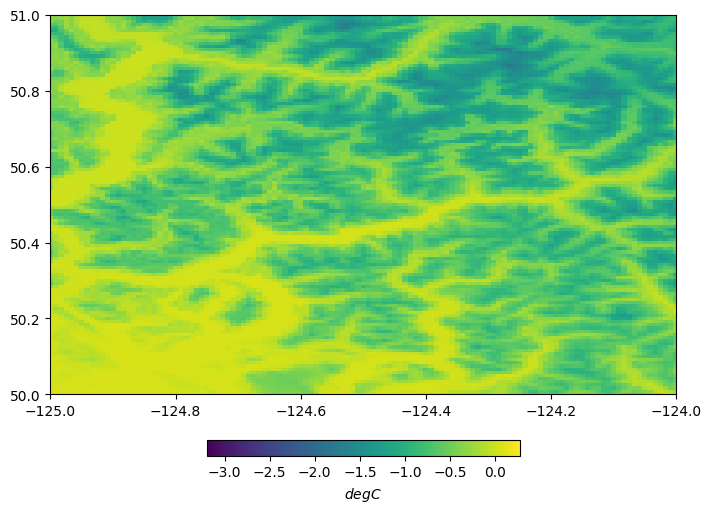

In [40]:
x = xr.open_dataset('C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_march_monthly_nonan_extra_cov/prism_train.nc')

fig, ax = plt.subplots(1, 1, layout='constrained', figsize=(7, 5), sharex=True, sharey=True)

pc1 = ax.pcolormesh(x.longitude, x.latitude, x.tmax[1], cmap='viridis', label=r'$m$')

ax.set_ylim(50,51)
ax.set_xlim(-125,-124)

fig.colorbar(pc1, shrink=0.5, aspect=20, location='bottom', label=r'$deg C$')

In [42]:
prism_pt = np.array(prism.tmax)
wrf_pt = np.array(wrf.tmax)
coast_pt = np.array(coast.dist)
dem_pt = np.array(dem.dem)
lat_pt = np.array(lat.lat)
lon_pt = np.array(lon.lon)
month_pt = np.array(months)

In [41]:
prism_slope_pt = np.array(prism_slope.slope)
prism_aspect_pt = np.array(prism_aspect.aspect)
prism_tpi_pt = np.array(prism_tpi.TPI)

wrf_slope_pt = np.array(wrf_slope.slope)
wrf_aspect_pt = np.array(wrf_aspect.aspect)
wrf_tpi_pt = np.array(wrf_tpi.TPI)
wrf_dem_pt = np.array(wrf_dem.DEM)

In [43]:
prism_test_pt = np.array(prism_test.tmax)
wrf_test_pt = np.array(wrf_test.tmax)
coast_test_pt = np.array(coast_test.dist)
dem_test_pt = np.array(dem_test.dem)
lat_test_pt = np.array(lat_test.lat)
lon_test_pt = np.array(lon_test.lon)

In [44]:
prism_slope_test_pt = np.array(prism_slope_test.slope)
prism_aspect_test_pt = np.array(prism_aspect_test.aspect)
prism_tpi_test_pt = np.array(prism_tpi_test.TPI)

wrf_slope_test_pt = np.array(wrf_slope_test.slope)
wrf_aspect_test_pt = np.array(wrf_aspect_test.aspect)
wrf_tpi_test_pt = np.array(wrf_tpi_test.TPI)
wrf_dem_test_pt = np.array(wrf_dem_test.DEM)

In [59]:
months_test = torch.zeros((12,wrf_test_pt.shape[1],wrf_test_pt.shape[2]))
for i in range(0,12):
    months_test[i] = i+1
month_test_pt = np.array(months_test)

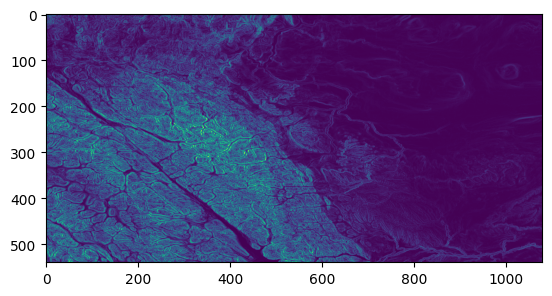

In [47]:
plt.imshow(prism_slope_test_pt)

In [48]:
prism_pt.shape

(12, 1524, 3216)

In [49]:
wrf_pt.shape

(12, 381, 804)

In [50]:
x_fine = np.arange(0,prism_pt.shape[1]-128, 16)
y_fine = np.arange(0,prism_pt.shape[2]-128, 16)

x_coarse = np.arange(0,wrf_pt.shape[1]-32, 4)
y_coarse = np.arange(0,wrf_pt.shape[2]-32, 4)

In [51]:
wrf_test_pt.shape[1]

135

In [52]:
x_fine_test= np.arange(0,prism_test_pt.shape[1]-128, 16)
y_fine_test = np.arange(0,prism_test_pt.shape[2]-128, 16)

x_coarse_test = np.arange(0,wrf_test_pt.shape[1]-32, 4)
y_coarse_test = np.arange(0,wrf_test_pt.shape[2]-32, 4)

In [53]:
tiles_fine_prism = []
tiles_fine_coast = []
tiles_fine_dem = []
tiles_fine_lat = []
tiles_fine_lon = []
tiles_fine_slope = []
tiles_fine_aspect = []
tiles_fine_tpi = []
for m in range(0,12):
    for i in range(0, len(y_fine)):
        prism = prism_pt[m][:,0+y_fine[i]:128+y_fine[i]]
        coast = coast_pt[:,0+y_fine[i]:128+y_fine[i]]
        dem = dem_pt[:,0+y_fine[i]:128+y_fine[i]]
        lat = lat_pt[:,0+y_fine[i]:128+y_fine[i]]
        lon = lon_pt[:,0+y_fine[i]:128+y_fine[i]]
        slope = prism_slope_pt[:,0+y_fine[i]:128+y_fine[i]]
        aspect = prism_aspect_pt[:,0+y_fine[i]:128+y_fine[i]]
        tpi = prism_tpi_pt[:,0+y_fine[i]:128+y_fine[i]]
        for j in range(0, len(x_fine)):
            tiles_fine_prism.append(prism[0+x_fine[j]:128+x_fine[j]])
            tiles_fine_coast.append(coast[0+x_fine[j]:128+x_fine[j]])
            tiles_fine_dem.append(dem[0+x_fine[j]:128+x_fine[j]])
            tiles_fine_lat.append(lat[0+x_fine[j]:128+x_fine[j]])
            tiles_fine_lon.append(lon[0+x_fine[j]:128+x_fine[j]])
            tiles_fine_slope.append(slope[0+x_fine[j]:128+x_fine[j]])
            tiles_fine_aspect.append(aspect[0+x_fine[j]:128+x_fine[j]])
            tiles_fine_tpi.append(tpi[0+x_fine[j]:128+x_fine[j]])

In [54]:
len(tiles_fine_prism)

203808

In [55]:
len(tiles_fine_coast)

203808

In [56]:
tiles_fine_prism_test = []
tiles_fine_coast_test = []
tiles_fine_dem_test = []
tiles_fine_lat_test = []
tiles_fine_lon_test = []
tiles_fine_slope_test = []
tiles_fine_aspect_test = []
tiles_fine_tpi_test = []
for m in range(0,12):
    for i in range(0, len(y_fine_test)):
        prism = prism_test_pt[m][:,0+y_fine_test[i]:128+y_fine_test[i]]
        coast = coast_test_pt[:,0+y_fine_test[i]:128+y_fine_test[i]]
        dem = dem_test_pt[:,0+y_fine_test[i]:128+y_fine_test[i]]
        lat = lat_test_pt[:,0+y_fine_test[i]:128+y_fine_test[i]]
        lon = lon_test_pt[:,0+y_fine_test[i]:128+y_fine_test[i]]
        slope = prism_slope_test_pt[:,0+y_fine[i]:128+y_fine[i]]
        aspect = prism_aspect_test_pt[:,0+y_fine[i]:128+y_fine[i]]
        tpi = prism_tpi_test_pt[:,0+y_fine[i]:128+y_fine[i]]
        for j in range(0, len(x_fine_test)):
            tiles_fine_prism_test.append(prism[0+x_fine_test[j]:128+x_fine_test[j]])
            tiles_fine_coast_test.append(coast[0+x_fine_test[j]:128+x_fine_test[j]])
            tiles_fine_dem_test.append(dem[0+x_fine_test[j]:128+x_fine_test[j]])
            tiles_fine_lat_test.append(lat[0+x_fine_test[j]:128+x_fine_test[j]])
            tiles_fine_lon_test.append(lon[0+x_fine_test[j]:128+x_fine_test[j]])
            tiles_fine_slope_test.append(slope[0+x_fine[j]:128+x_fine[j]])
            tiles_fine_aspect_test.append(aspect[0+x_fine[j]:128+x_fine[j]])
            tiles_fine_tpi_test.append(tpi[0+x_fine[j]:128+x_fine[j]])

In [60]:
tiles_coarse_wrf = []
tiles_coarse_month = []
tiles_coarse_slope = []
tiles_coarse_aspect = []
tiles_coarse_tpi = []
tiles_coarse_dem = []
for m in range(0,12):
    for i in range(0, len(y_coarse)):
        wrf = wrf_pt[m][:,0+y_coarse[i]:32+y_coarse[i]]
        month = month_pt[m][:,0+y_coarse[i]:32+y_coarse[i]]
        slope = wrf_slope_pt[:,0+y_coarse[i]:32+y_coarse[i]]
        aspect = wrf_aspect_pt[:,0+y_coarse[i]:32+y_coarse[i]]
        tpi = wrf_tpi_pt[:,0+y_coarse[i]:32+y_coarse[i]]
        dem = wrf_dem_pt[:,0+y_coarse[i]:32+y_coarse[i]]
        for j in range(0, len(x_coarse)):
            tiles_coarse_wrf.append(wrf[0+x_coarse[j]:32+x_coarse[j]])
            tiles_coarse_month.append(month[0+x_coarse[j]:32+x_coarse[j]])
            tiles_coarse_slope.append(slope[0+x_coarse[j]:32+x_coarse[j]])
            tiles_coarse_aspect.append(aspect[0+x_coarse[j]:32+x_coarse[j]])
            tiles_coarse_tpi.append(tpi[0+x_coarse[j]:32+x_coarse[j]])
            tiles_coarse_dem.append(dem[0+x_coarse[j]:32+x_coarse[j]])

In [61]:
tiles_coarse_wrf_test = []
tiles_coarse_month_test = []
tiles_coarse_slope_test = []
tiles_coarse_aspect_test = []
tiles_coarse_tpi_test = []
tiles_coarse_dem_test = []
for m in range(0,12):
    for i in range(0, len(y_coarse_test)):
        wrf = wrf_test_pt[m][:,0+y_coarse_test[i]:32+y_coarse_test[i]]
        month = month_test_pt[m][:,0+y_coarse_test[i]:32+y_coarse_test[i]]
        slope = wrf_slope_test_pt[:,0+y_coarse[i]:32+y_coarse[i]]
        aspect = wrf_aspect_test_pt[:,0+y_coarse[i]:32+y_coarse[i]]
        tpi = wrf_tpi_test_pt[:,0+y_coarse[i]:32+y_coarse[i]]
        dem = wrf_dem_test_pt[:,0+y_coarse[i]:32+y_coarse[i]]
        for j in range(0, len(x_coarse_test)):
            tiles_coarse_wrf_test.append(wrf[0+x_coarse_test[j]:32+x_coarse_test[j]])
            tiles_coarse_month_test.append(month[0+x_coarse_test[j]:32+x_coarse[j]])
            tiles_coarse_slope_test.append(slope[0+x_coarse[j]:32+x_coarse[j]])
            tiles_coarse_aspect_test.append(aspect[0+x_coarse[j]:32+x_coarse[j]])
            tiles_coarse_tpi_test.append(tpi[0+x_coarse[j]:32+x_coarse[j]])
            tiles_coarse_dem_test.append(dem[0+x_coarse[j]:32+x_coarse[j]])

In [125]:
# create for all covariates 
# wrf and HR 
# calculate which tiles have NAN values based on PRISM grid and then do the same to the other ones  
# throw out ones with all nan 


In [62]:
coast_pt.shape

(1524, 3216)

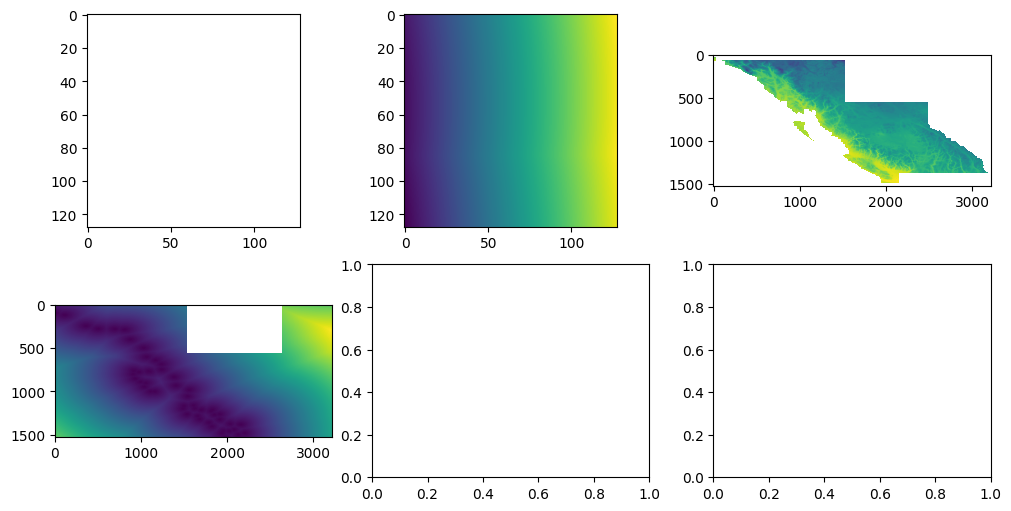

In [63]:
i = -1
fig, ax = plt.subplots(2, 3, layout='constrained', figsize=(10, 5))

pc1 = ax[0,0].imshow(tiles_fine_prism[i])

pc1 = ax[0,1].imshow(np.nan_to_num(tiles_fine_coast[i], nan=np.nanmean(tiles_fine_coast[i])))
pc3 = ax[0,2].imshow(prism_pt[0])
pc4 = ax[1,0].imshow(coast_pt)

In [64]:
size_fine = 128*128
size_coarse = 32*32

good_tiles_prism = []
good_tiles_dem = []
good_tiles_coast = []
good_tiles_lat = []
good_tiles_lon = []
good_tiles_prism_slope = []
good_tiles_prism_aspect = []
good_tiles_prism_tpi = []

good_tiles_wrf = []
good_tiles_month = []
good_tiles_wrf_slope = []
good_tiles_wrf_aspect = []
good_tiles_wrf_tpi = []
good_tiles_wrf_dem = []

for i in range(0, len(tiles_fine_prism)):
    ind = np.argwhere(np.isnan(tiles_fine_prism[i]))
    percent_nan_prism = ind.shape[0]/size_fine *100
    ind = np.argwhere(np.isnan(tiles_coarse_wrf[i]))
    percent_nan_wrf = ind.shape[0]/size_coarse *100
    if ((percent_nan_prism == 0) & (percent_nan_wrf==0)):
        good_tiles_prism.append(tiles_fine_prism[i])
        good_tiles_dem.append(tiles_fine_dem[i])
        good_tiles_coast.append(tiles_fine_coast[i])
        good_tiles_lat.append(tiles_fine_lat[i])
        good_tiles_lon.append(tiles_fine_lon[i])
        good_tiles_prism_slope.append(tiles_fine_slope[i])
        good_tiles_prism_aspect.append(tiles_fine_aspect[i])
        good_tiles_prism_tpi.append(tiles_fine_tpi[i])
        
        good_tiles_wrf.append(tiles_coarse_wrf[i])
        good_tiles_month.append(tiles_coarse_month[i])
        good_tiles_wrf_slope.append(tiles_coarse_slope[i])
        good_tiles_wrf_aspect.append(tiles_coarse_aspect[i])
        good_tiles_wrf_tpi.append(tiles_coarse_tpi[i])
        good_tiles_wrf_dem.append(tiles_coarse_dem[i])

In [65]:
good_tiles_prism_test = []
good_tiles_dem_test = []
good_tiles_coast_test = []
good_tiles_lat_test = []
good_tiles_lon_test = []
good_tiles_prism_slope_test = []
good_tiles_prism_aspect_test = []
good_tiles_prism_tpi_test = []

good_tiles_wrf_test = []
good_tiles_month_test = []
good_tiles_wrf_slope_test = []
good_tiles_wrf_aspect_test = []
good_tiles_wrf_tpi_test = []
good_tiles_wrf_dem_test = []

for i in range(0, len(tiles_fine_prism_test)):
    ind = np.argwhere(np.isnan(tiles_fine_prism_test[i]))
    percent_nan_prism = ind.shape[0]/size_fine *100
    ind = np.argwhere(np.isnan(tiles_coarse_wrf_test[i]))
    percent_nan_wrf = ind.shape[0]/size_coarse *100
    if ((percent_nan_prism == 0) & (percent_nan_wrf==0)):
        good_tiles_prism_test.append(tiles_fine_prism_test[i])
        good_tiles_dem_test.append(tiles_fine_dem_test[i])
        good_tiles_coast_test.append(tiles_fine_coast_test[i])
        good_tiles_lat_test.append(tiles_fine_lat_test[i])
        good_tiles_lon_test.append(tiles_fine_lon_test[i])
        
        good_tiles_prism_slope_test.append(tiles_fine_slope_test[i])
        good_tiles_prism_aspect_test.append(tiles_fine_aspect_test[i])
        good_tiles_prism_tpi_test.append(tiles_fine_tpi_test[i])
        
        good_tiles_wrf_test.append(tiles_coarse_wrf_test[i])
        good_tiles_month_test.append(tiles_coarse_month_test[i])
        good_tiles_wrf_slope_test.append(tiles_coarse_slope_test[i])
        good_tiles_wrf_aspect_test.append(tiles_coarse_aspect_test[i])
        good_tiles_wrf_tpi_test.append(tiles_coarse_tpi_test[i])
        good_tiles_wrf_dem_test.append(tiles_coarse_dem_test[i])

In [66]:
del tiles_fine_prism 
del tiles_coarse_wrf
del tiles_fine_dem
del tiles_fine_coast
del tiles_fine_lat
del tiles_fine_lon
del tiles_coarse_month

In [67]:
import gc
gc.collect()

3203

In [68]:
del tiles_fine_prism_test
del tiles_coarse_wrf_test
del tiles_fine_dem_test
del tiles_fine_coast_test
del tiles_fine_lat_test
del tiles_fine_lon_test
del tiles_coarse_month_test

In [69]:
gc.collect()

0

In [70]:

good_tiles_coast[-1].shape

(128, 128)

In [71]:
len(good_tiles_prism)

57336

In [72]:
tiles_unsq = [x.unsqueeze(0) for x in torch.as_tensor(np.array(good_tiles_prism))]
good_tiles_prism = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)
torch.save(good_tiles_prism, 'C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_march_monthly_nonan_extra_cov/prism_train.pt')

del good_tiles_prism
del tiles_unsq

gc.collect()

0

In [73]:
tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_wrf))]
good_tiles_wrf = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)

del tiles_unsq

tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_month))]
good_tiles_month = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)

del tiles_unsq

tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_wrf_slope))]
good_tiles_wrf_slope = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)

del tiles_unsq

tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_wrf_aspect))]
good_tiles_wrf_aspect = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)

del tiles_unsq

tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_wrf_tpi))]
good_tiles_wrf_tpi = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)

del tiles_unsq

tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_wrf_dem))]
good_tiles_wrf_dem = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)

del tiles_unsq

gc.collect()

0

In [74]:
x = torch.cat((good_tiles_wrf, good_tiles_month, good_tiles_wrf_slope, good_tiles_wrf_aspect, good_tiles_wrf_tpi, good_tiles_wrf_dem), dim=1)
x.shape

torch.Size([57336, 6, 32, 32])

In [75]:
torch.save(x, 'C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_march_monthly_nonan_extra_cov/wrf_train.pt')

del good_tiles_wrf 
del good_tiles_month 
del good_tiles_wrf_slope
del good_tiles_wrf_aspect
del good_tiles_wrf_tpi
del good_tiles_wrf_dem

gc.collect()

23

In [76]:
tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_dem))]
good_tiles_dem = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)

del tiles_unsq

tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_coast))]
good_tiles_coast = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)

del tiles_unsq

tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_lat))]
good_tiles_lat = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)

del tiles_unsq

tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_lon))]
good_tiles_lon = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)

del tiles_unsq

tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_prism_slope))]
good_tiles_prism_slope = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)

del tiles_unsq

tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_prism_aspect))]
good_tiles_prism_aspect = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)

del tiles_unsq

tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_prism_tpi))]
good_tiles_prism_tpi = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)

del tiles_unsq

gc.collect()

0

In [77]:
x = torch.cat((good_tiles_dem, good_tiles_lat, good_tiles_lon, good_tiles_coast, good_tiles_prism_slope, good_tiles_prism_aspect, good_tiles_prism_tpi), dim=1)
x.shape

torch.Size([57336, 7, 128, 128])

In [78]:
torch.save(x, 'C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_march_monthly_nonan_extra_cov/HR_covariates_train.pt')

del x 
del good_tiles_dem
del good_tiles_lat
del good_tiles_lon
del good_tiles_coast
del good_tiles_prism_slope
del good_tiles_prism_aspect
del good_tiles_prism_tpi

gc.collect()

7

In [79]:
tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_prism_test))]
good_tiles_prism_test = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)
torch.save(good_tiles_prism_test, 'C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_march_monthly_nonan_extra_cov/prism_test.pt')

del good_tiles_prism_test
del tiles_unsq

gc.collect()

0

In [80]:
tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_wrf_test))]
good_tiles_wrf_test = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)

del tiles_unsq

tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_month_test))]
good_tiles_month_test = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)

del tiles_unsq

tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_wrf_slope_test))]
good_tiles_wrf_slope_test = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)

del tiles_unsq

tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_wrf_aspect_test))]
good_tiles_wrf_aspect_test = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)

del tiles_unsq

tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_wrf_tpi_test))]
good_tiles_wrf_tpi_test = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)

del tiles_unsq

tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_wrf_dem_test))]
good_tiles_wrf_dem_test = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)

del tiles_unsq

gc.collect()

0

In [81]:
x = torch.cat((good_tiles_wrf_test, good_tiles_month_test, good_tiles_wrf_slope_test, good_tiles_wrf_aspect_test, good_tiles_wrf_tpi_test, good_tiles_wrf_dem_test), dim=1)
x.shape

torch.Size([13992, 6, 32, 32])

In [82]:
torch.save(x, 'C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_march_monthly_nonan_extra_cov/wrf_test.pt')

del good_tiles_wrf_test
del good_tiles_month_test
del x
del good_tiles_wrf_slope_test
del good_tiles_wrf_aspect_test
del good_tiles_wrf_tpi_test
del good_tiles_wrf_dem_test

gc.collect()

14

In [83]:
tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_dem_test))]
good_tiles_dem_test = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)

del tiles_unsq

tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_coast_test))]
good_tiles_coast_test = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)

del tiles_unsq

tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_lat_test))]
good_tiles_lat_test = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)

del tiles_unsq

tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_lon_test))]
good_tiles_lon_test = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)

del tiles_unsq

tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_prism_slope_test))]
good_tiles_prism_slope_test = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)

del tiles_unsq

tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_prism_aspect_test))]
good_tiles_prism_aspect_test = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)

del tiles_unsq

tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_prism_tpi_test))]
good_tiles_prism_tpi_test = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)


del tiles_unsq

In [84]:
x = torch.cat((good_tiles_dem_test, good_tiles_lat_test, good_tiles_lon_test, good_tiles_coast_test, good_tiles_prism_slope_test, good_tiles_prism_aspect_test, good_tiles_prism_tpi_test), dim=1)
x.shape

torch.Size([13992, 7, 128, 128])

In [85]:
torch.save(x, 'C:/Users/SBEALE/Desktop/GAN Data/tmax/tmax_march_monthly_nonan_extra_cov/HR_covariates_test.pt')

del x
del good_tiles_dem_test
del good_tiles_lat_test
del good_tiles_lon_test
del good_tiles_coast_test
del good_tiles_prism_aspect_test
del good_tiles_prism_slope_test
del good_tiles_prism_tpi_test